# 학습 결과

user1의 scene 1~3만 사용해서 학습

scene보다 user가 많기 때문에 데이터의 양이 확연히 줄어듬에도 불구하고 성능이 괜찮음.  
적은 데이터 특화됐기 때문인지는 모르겠다.

나머지 scene에 대해서도 잘 학습을 하면서 user에 대해서도 특화된다면 성능을 상당히 끌어올릴 수 있을 것으로 기대됨.  
--> curriculum learning

In [1]:
from multiprocessing import cpu_count
from pathlib import Path
from typing import List, Union, AnyStr
from math import pi
import pickle

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import model_selection
from tqdm import tqdm
import torch_optimizer
from torch.utils.data import Dataset
import pandas as pd
import random

import torch_burn as tb
import utils

In [2]:
EXPERIMENT_NAME = '1122-Scene3-CLSTM2-GCNN-win60'
CHECKPOINT_DIR = Path('checkpoint', EXPERIMENT_NAME)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path('data/1116')
TRAIN_FILES = sorted(list(DATA_DIR.glob('*scene3_0.csv')))
TEST_FILES = sorted(list(DATA_DIR.glob('*scene3_1.csv')))

# 데이터셋 생성

scene1에 대해서 모든 user의 데이터를 하나로 합친다.

In [3]:
WINDOW_SIZE = 60

In [4]:
class CSVSequentialDataset(Dataset):
    def __init__(self, csvfile,
                 window_size=300, randomized_window_size=False,
                 stride=30, randomized_stride=False):
        super(CSVSequentialDataset, self).__init__()

        self.xcols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll',
                      'acceleration_x', 'acceleration_y', 'acceleration_z']
        self.ycols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll']

        self.csv = pd.read_csv(csvfile)
        self.window_size = window_size

        self.indexes = []
        i = 0
        while i <= len(self.csv) - window_size * 2:
            if randomized_window_size:
                self.indexes.append((i, i + random.randint(window_size // 2, window_size)))
            else:
                self.indexes.append((i, i + window_size))

            if randomized_stride:
                i += random.randint(1, stride)
            else:
                i += stride

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        s, t = self.indexes[idx]
        x = self.csv.iloc[s:t][self.xcols].to_numpy()
        y = self.csv.iloc[t + 6][self.ycols].to_numpy()

        x = torch.tensor(x, dtype=torch.float32) # 300, 6
        y = torch.tensor(y, dtype=torch.float32) # 3
        
        #x[:, :3] *= pi / 180
        x[:, 3:] /= 10

        return x, y

In [5]:
ds_train = [CSVSequentialDataset(f,  
                                 window_size=WINDOW_SIZE, randomized_window_size=False,
                                 stride=5, randomized_stride=True) for f in TRAIN_FILES]
ds_train = tb.data.ChainDataset(*ds_train)
ds_test = [CSVSequentialDataset(f,  
                                window_size=WINDOW_SIZE, randomized_window_size=False,
                                stride=5, randomized_stride=True) for f in TEST_FILES]
ds_test = tb.data.ChainDataset(*ds_test)

In [6]:
len(ds_train), len(ds_test)

(18810, 18177)

In [7]:
ds_train[0][0].shape, ds_train[0][1].shape

(torch.Size([60, 6]), torch.Size([3]))

In [8]:
x, y = ds_train[0]

In [9]:
x.shape

torch.Size([60, 6])

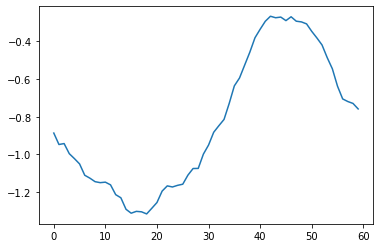

In [10]:
plt.plot(x[:, 2])

# 모델 생성

In [11]:
class CLSTM(nn.Module):
    def __init__(self, input_size=6, hidden_size=24, num_layers=8, dropout=0.0, bidirectional=False):
        super(CLSTM, self).__init__()

        self.conv_in = nn.Sequential(
            nn.Conv1d(input_size, 12, 5, padding=2, groups=2),
            nn.BatchNorm1d(12),
            nn.LeakyReLU(),
            nn.Conv1d(12, 24, 5, padding=2),
            nn.BatchNorm1d(24),
        )

        self.rnn = nn.LSTM(input_size=24,
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           batch_first=True,
                           dropout=dropout,
                           bidirectional=bidirectional)

        out_channels = 2 * hidden_size if bidirectional else hidden_size
        self.fc = nn.Linear(out_channels, 3)

    def forward(self, x):
        x = x.transpose(1, 2)  # B, 48, 6 --> B, 6, 48
        x = self.conv_in(x)  # B, 64, 48
        x = x.transpose(1, 2)  # B, 48, 64

        outs, (hiddens, cells) = self.rnn(x)
        x = outs[:, -1, ...]
        x = self.fc(x)

        return x

In [12]:
model = CLSTM(input_size=6, hidden_size=64, num_layers=8, dropout=0.2, bidirectional=True).cuda()

In [13]:
criterion = nn.MSELoss().cuda()
optimizer = torch_optimizer.RAdam(model.parameters())

In [14]:
metrics = [tb.metrics.ModuleMetric(criterion, 'loss'),
           utils.HPMetric('hp_metric'),
           utils.HPSignalHistory(CHECKPOINT_DIR / 'sample' / '{epoch:04d}.npy', 'hp_signal')]

In [15]:
callbacks = [tb.callbacks.EarlyStopping(metrics[0]),
             tb.callbacks.LRDecaying(optimizer, metrics[0])]

In [16]:
trainer = tb.Trainer(model, optimizer, metrics, callbacks, ncols=100)

In [17]:
trainer.fit(ds_train, ds_test, num_epochs=100, batch_size=256, shuffle=True, pin_memory=True)

[0002/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :  18.987236
 - Pitch        :  10.055202
 - Roll         :   2.580120
 - RMS          :  12.493722
 - 99% Tile     :  43.576655
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0001.npy


[0003/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :  15.380226
 - Pitch        :   8.925334
 - Roll         :   2.550181
 - RMS          :  10.371698
 - 99% Tile     :  40.061341
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0002.npy


[0004/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :  11.976599
 - Pitch        :   8.573917
 - Roll         :   2.412032
 - RMS          :   8.617209
 - 99% Tile     :  34.121802
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0003.npy


[0005/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :  10.261410
 - Pitch        :   7.772922
 - Roll         :   2.389903
 - RMS          :   7.559244
 - 99% Tile     :  30.709984
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0004.npy


[0006/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   9.939695
 - Pitch        :   6.893267
 - Roll         :   2.389472
 - RMS          :   7.118620
 - 99% Tile     :  27.956600
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0005.npy


[0007/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   7.914570
 - Pitch        :   6.937367
 - Roll         :   2.395451
 - RMS          :   6.231791
 - 99% Tile     :  25.544344
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0006.npy


[0008/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   6.541382
 - Pitch        :   6.762585
 - Roll         :   2.372139
 - RMS          :   5.602061
 - 99% Tile     :  24.569405
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0007.npy


[0009/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   5.464609
 - Pitch        :   7.004905
 - Roll         :   2.348824
 - RMS          :   5.305583
 - 99% Tile     :  22.861292
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0008.npy


[0010/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   4.818790
 - Pitch        :   6.784779
 - Roll         :   2.334614
 - RMS          :   4.990137
 - 99% Tile     :  22.078078
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0009.npy


[0011/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   4.619475
 - Pitch        :   6.714156
 - Roll         :   2.369461
 - RMS          :   4.900129
 - 99% Tile     :  21.127481
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0010.npy


[0012/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.706717
 - Pitch        :   6.729342
 - Roll         :   2.307802
 - RMS          :   4.631405
 - 99% Tile     :  20.458751
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0011.npy


[0013/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.865656
 - Pitch        :   6.522947
 - Roll         :   2.272817
 - RMS          :   4.570115
 - 99% Tile     :  20.420509
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0012.npy


[0014/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.610354
 - Pitch        :   6.496861
 - Roll         :   2.301535
 - RMS          :   4.492250
 - 99% Tile     :  20.594160
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0013.npy


[0015/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.343930
 - Pitch        :   6.291872
 - Roll         :   2.308036
 - RMS          :   4.324217
 - 99% Tile     :  20.360799
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0014.npy


[0016/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   4.008550
 - Pitch        :   6.213079
 - Roll         :   2.360194
 - RMS          :   4.481121
 - 99% Tile     :  20.068890
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0015.npy


[0017/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.113797
 - Pitch        :   6.167644
 - Roll         :   2.327960
 - RMS          :   4.209313
 - 99% Tile     :  20.579841
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0016.npy


[0018/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.822154
 - Pitch        :   6.311064
 - Roll         :   2.285802
 - RMS          :   4.203926
 - 99% Tile     :  21.378236
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0017.npy


[0019/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.922097
 - Pitch        :   4.480429
 - Roll         :   2.310008
 - RMS          :   3.363977
 - 99% Tile     :  17.105326
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0018.npy


[0020/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.371081
 - Pitch        :   3.451312
 - Roll         :   2.336005
 - RMS          :   2.768302
 - 99% Tile     :  16.097345
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0019.npy


[0021/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.046786
 - Pitch        :   2.454277
 - Roll         :   2.323683
 - RMS          :   2.281250
 - 99% Tile     :  11.279736
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0020.npy


[0022/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.837773
 - Pitch        :   2.028791
 - Roll         :   2.290684
 - RMS          :   2.060796
 - 99% Tile     :   9.970711
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0021.npy


[0023/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.689586
 - Pitch        :   1.710211
 - Roll         :   2.319495
 - RMS          :   1.928694
 - 99% Tile     :   9.068843
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0022.npy


[0024/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.539449
 - Pitch        :   1.688442
 - Roll         :   2.264445
 - RMS          :   1.857278
 - 99% Tile     :   8.547568
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0023.npy


[0025/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.420867
 - Pitch        :   1.511836
 - Roll         :   2.259306
 - RMS          :   1.770967
 - 99% Tile     :   8.188414
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0024.npy


[0026/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.926369
 - Pitch        :   1.717849
 - Roll         :   2.230824
 - RMS          :   1.969643
 - 99% Tile     :   8.155431
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0025.npy


[0027/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.294534
 - Pitch        :   1.319256
 - Roll         :   2.273889
 - RMS          :   1.691826
 - 99% Tile     :   7.811272
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0026.npy


[0028/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   3.160206
 - Pitch        :   1.399451
 - Roll         :   2.185750
 - RMS          :   2.360993
 - 99% Tile     :   8.082187
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0027.npy


[0029/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.468460
 - Pitch        :   1.548390
 - Roll         :   2.230253
 - RMS          :   1.782125
 - 99% Tile     :   7.810614
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0028.npy


[0030/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.809214
 - Pitch        :   1.219619
 - Roll         :   2.237361
 - RMS          :   1.804301
 - 99% Tile     :   7.415505
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0029.npy


[0031/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.693772
 - Pitch        :   1.203093
 - Roll         :   2.214706
 - RMS          :   1.753208
 - 99% Tile     :   7.233268
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0030.npy


[0032/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.327330
 - Pitch        :   1.408190
 - Roll         :   2.248190
 - RMS          :   1.712616
 - 99% Tile     :   7.340910
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0031.npy


[0033/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.427878
 - Pitch        :   1.271171
 - Roll         :   2.227013
 - RMS          :   1.694530
 - 99% Tile     :   7.085244
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0032.npy


[0034/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.653839
 - Pitch        :   1.225334
 - Roll         :   2.214518
 - RMS          :   1.745539
 - 99% Tile     :   7.227960
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0033.npy


[0035/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.512882
 - Pitch        :   1.069309
 - Roll         :   2.228187
 - RMS          :   1.673026
 - 99% Tile     :   6.895661
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0034.npy


[0036/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.914273
 - Pitch        :   1.901752
 - Roll         :   2.214519
 - RMS          :   2.015374
 - 99% Tile     :   7.322945
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0035.npy


[0037/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.241109
 - Pitch        :   1.532559
 - Roll         :   2.258537
 - RMS          :   1.731095
 - 99% Tile     :   6.943516
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0036.npy


[0038/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.785630
 - Pitch        :   1.053157
 - Roll         :   2.234535
 - RMS          :   1.759807
 - 99% Tile     :   6.818353
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0037.npy


[0039/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.768787
 - Pitch        :   1.025697
 - Roll         :   2.268053
 - RMS          :   1.763021
 - 99% Tile     :   6.911891
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0038.npy


[0040/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.348721
 - Pitch        :   0.912921
 - Roll         :   2.224228
 - RMS          :   1.591609
 - 99% Tile     :   6.689941
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0039.npy


[0041/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.595211
 - Pitch        :   1.055372
 - Roll         :   2.174728
 - RMS          :   1.672119
 - 99% Tile     :   6.664691
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0040.npy


[0042/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.306639
 - Pitch        :   1.334386
 - Roll         :   2.214891
 - RMS          :   1.672686
 - 99% Tile     :   6.743890
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0041.npy


[0043/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.245561
 - Pitch        :   0.981192
 - Roll         :   2.246993
 - RMS          :   1.587780
 - 99% Tile     :   6.977950
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0042.npy


[0044/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.417776
 - Pitch        :   1.044837
 - Roll         :   2.253534
 - RMS          :   1.651281
 - 99% Tile     :   6.820232
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0043.npy


[0045/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

Decaying lr from 0.001 to 0.0005 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   1.362841
 - Pitch        :   1.050987
 - Roll         :   2.213120
 - RMS          :   1.618622
 - 99% Tile     :   6.604144
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0044.npy


[0046/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.045679
 - Pitch        :   1.063169
 - Roll         :   2.208982
 - RMS          :   1.538763
 - 99% Tile     :   6.627242
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0045.npy


[0047/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.155804
 - Pitch        :   0.949977
 - Roll         :   2.208878
 - RMS          :   1.540290
 - 99% Tile     :   6.465206
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0046.npy


[0048/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.072536
 - Pitch        :   0.905771
 - Roll         :   2.213675
 - RMS          :   1.513397
 - 99% Tile     :   6.615329
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0047.npy


[0049/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.047675
 - Pitch        :   0.875377
 - Roll         :   2.196155
 - RMS          :   1.492984
 - 99% Tile     :   6.449860
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0048.npy


[0050/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.283244
 - Pitch        :   1.138416
 - Roll         :   2.196398
 - RMS          :   1.609023
 - 99% Tile     :   6.590424
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0049.npy


[0051/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.516024
 - Pitch        :   0.991596
 - Roll         :   2.207516
 - RMS          :   1.648708
 - 99% Tile     :   6.503865
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0050.npy


[0052/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.147439
 - Pitch        :   0.859553
 - Roll         :   2.260019
 - RMS          :   1.545222
 - 99% Tile     :   6.570822
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0051.npy


[0053/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.153445
 - Pitch        :   0.920665
 - Roll         :   2.316054
 - RMS          :   1.585577
 - 99% Tile     :   6.606460
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0052.npy


[0054/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

Decaying lr from 0.0005 to 0.00025 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   1.157149
 - Pitch        :   0.965566
 - Roll         :   2.217206
 - RMS          :   1.547828
 - 99% Tile     :   6.723859
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0053.npy


[0055/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   1.015919
 - Pitch        :   0.848845
 - Roll         :   2.233681
 - RMS          :   1.499107
 - 99% Tile     :   6.644090
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0054.npy


[0056/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.016338
 - Pitch        :   0.852407
 - Roll         :   2.231550
 - RMS          :   1.498817
 - 99% Tile     :   6.479166
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0055.npy


[0057/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.053013
 - Pitch        :   0.885716
 - Roll         :   2.223344
 - RMS          :   1.509590
 - 99% Tile     :   6.509842
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0056.npy


[0058/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.063637
 - Pitch        :   0.866940
 - Roll         :   2.225325
 - RMS          :   1.509413
 - 99% Tile     :   6.527922
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0057.npy


[0059/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.039381
 - Pitch        :   0.867899
 - Roll         :   2.230033
 - RMS          :   1.506276
 - 99% Tile     :   6.543991
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0058.npy


[0060/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.207216
 - Pitch        :   0.837927
 - Roll         :   2.203492
 - RMS          :   1.529147
 - 99% Tile     :   6.524137
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0059.npy


[0061/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

Decaying lr from 0.00025 to 0.000125 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   1.086150
 - Pitch        :   0.848654
 - Roll         :   2.224786
 - RMS          :   1.511027
 - 99% Tile     :   6.481612
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0060.npy


[0062/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.949404
 - Pitch        :   0.822773
 - Roll         :   2.225372
 - RMS          :   1.475421
 - 99% Tile     :   6.497745
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0061.npy


[0063/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.919772
 - Pitch        :   0.866759
 - Roll         :   2.220204
 - RMS          :   1.474964
 - 99% Tile     :   6.478062
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0062.npy


[0064/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.942146
 - Pitch        :   0.851744
 - Roll         :   2.208129
 - RMS          :   1.470707
 - 99% Tile     :   6.531265
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0063.npy


[0065/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.981114
 - Pitch        :   0.824779
 - Roll         :   2.215754
 - RMS          :   1.477882
 - 99% Tile     :   6.445610
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0064.npy


[0066/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.934870
 - Pitch        :   0.851055
 - Roll         :   2.203274
 - RMS          :   1.466594
 - 99% Tile     :   6.432670
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0065.npy


[0067/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.953739
 - Pitch        :   0.836180
 - Roll         :   2.206500
 - RMS          :   1.469405
 - 99% Tile     :   6.418068
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0066.npy


[0068/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.951655
 - Pitch        :   0.841685
 - Roll         :   2.214441
 - RMS          :   1.473978
 - 99% Tile     :   6.487792
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0067.npy


[0069/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.935818
 - Pitch        :   0.873428
 - Roll         :   2.199861
 - RMS          :   1.469469
 - 99% Tile     :   6.539839
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0068.npy


[0070/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.940985
 - Pitch        :   0.854740
 - Roll         :   2.214121
 - RMS          :   1.474038
 - 99% Tile     :   6.553400
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0069.npy


[0071/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

Decaying lr from 0.000125 to 6.25e-05 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   0.963616
 - Pitch        :   0.874227
 - Roll         :   2.196418
 - RMS          :   1.473893
 - 99% Tile     :   6.613595
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0070.npy


[0072/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   0.978958
 - Pitch        :   0.832089
 - Roll         :   2.208961
 - RMS          :   1.475380
 - 99% Tile     :   6.559504
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0071.npy


[0073/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 7 epochs
                  validation
 - Yaw          :   0.970189
 - Pitch        :   0.825547
 - Roll         :   2.201508
 - RMS          :   1.468495
 - 99% Tile     :   6.554581
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0072.npy


[0074/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.915141
 - Pitch        :   0.834962
 - Roll         :   2.201959
 - RMS          :   1.458683
 - 99% Tile     :   6.539026
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0073.npy


[0075/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.916269
 - Pitch        :   0.855287
 - Roll         :   2.200003
 - RMS          :   1.461857
 - 99% Tile     :   6.510256
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0074.npy


[0076/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.958313
 - Pitch        :   0.841687
 - Roll         :   2.203250
 - RMS          :   1.469820
 - 99% Tile     :   6.535260
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0075.npy


[0077/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.905106
 - Pitch        :   0.831544
 - Roll         :   2.220200
 - RMS          :   1.465147
 - 99% Tile     :   6.544159
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0076.npy


[0078/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.939208
 - Pitch        :   0.861578
 - Roll         :   2.190545
 - RMS          :   1.463206
 - 99% Tile     :   6.486428
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0077.npy


[0079/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.941550
 - Pitch        :   0.842071
 - Roll         :   2.203584
 - RMS          :   1.466445
 - 99% Tile     :   6.558280
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0078.npy


[0080/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.010613
 - Pitch        :   0.852429
 - Roll         :   2.212329
 - RMS          :   1.487994
 - 99% Tile     :   6.547743
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0079.npy


[0081/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.039311
 - Pitch        :   0.856872
 - Roll         :   2.190936
 - RMS          :   1.484879
 - 99% Tile     :   6.539086
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0080.npy


[0082/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.928695
 - Pitch        :   0.848175
 - Roll         :   2.190542
 - RMS          :   1.458350
 - 99% Tile     :   6.509078
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0081.npy


[0083/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.913970
 - Pitch        :   0.839737
 - Roll         :   2.203806
 - RMS          :   1.460281
 - 99% Tile     :   6.496033
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0082.npy


[0084/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.900160
 - Pitch        :   0.846917
 - Roll         :   2.205108
 - RMS          :   1.459458
 - 99% Tile     :   6.518136
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0083.npy


[0085/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.924006
 - Pitch        :   0.847197
 - Roll         :   2.187403
 - RMS          :   1.455594
 - 99% Tile     :   6.549588
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0084.npy


[0086/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.893919
 - Pitch        :   0.837606
 - Roll         :   2.197116
 - RMS          :   1.452353
 - 99% Tile     :   6.599539
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0085.npy


[0087/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

Decaying lr from 6.25e-05 to 3.125e-05 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   0.907656
 - Pitch        :   0.842942
 - Roll         :   2.199829
 - RMS          :   1.457582
 - 99% Tile     :   6.470909
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0086.npy


[0088/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.885144
 - Pitch        :   0.849059
 - Roll         :   2.196655
 - RMS          :   1.452547
 - 99% Tile     :   6.484059
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0087.npy


[0089/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.898306
 - Pitch        :   0.832232
 - Roll         :   2.197837
 - RMS          :   1.452590
 - 99% Tile     :   6.520540
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0088.npy


[0090/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.889905
 - Pitch        :   0.843191
 - Roll         :   2.195830
 - RMS          :   1.451961
 - 99% Tile     :   6.553363
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0089.npy


[0091/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.898042
 - Pitch        :   0.836562
 - Roll         :   2.192600
 - RMS          :   1.450725
 - 99% Tile     :   6.573163
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0090.npy


[0092/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.924294
 - Pitch        :   0.830535
 - Roll         :   2.200765
 - RMS          :   1.459164
 - 99% Tile     :   6.617787
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0091.npy


[0093/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

Decaying lr from 3.125e-05 to 1.5625e-05 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   0.890249
 - Pitch        :   0.844191
 - Roll         :   2.195165
 - RMS          :   1.451890
 - 99% Tile     :   6.510532
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0092.npy


[0094/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   0.942076
 - Pitch        :   0.839558
 - Roll         :   2.193513
 - RMS          :   1.461034
 - 99% Tile     :   6.560733
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0093.npy


[0095/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 7 epochs
                  validation
 - Yaw          :   0.905596
 - Pitch        :   0.841336
 - Roll         :   2.194791
 - RMS          :   1.454311
 - 99% Tile     :   6.568170
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0094.npy


[0096/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 8 epochs
                  validation
 - Yaw          :   0.901680
 - Pitch        :   0.846414
 - Roll         :   2.189675
 - RMS          :   1.451909
 - 99% Tile     :   6.560528
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0095.npy


[0097/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 9 epochs
                  validation
 - Yaw          :   0.877941
 - Pitch        :   0.842574
 - Roll         :   2.196384
 - RMS          :   1.449691
 - 99% Tile     :   6.584673
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0096.npy


[0097/0100] Validation: 100%|██████████████████████| 72/72 [00:02<00:00, 31.51it/s, val_loss 3.8137]


Decaying lr from 1.5625e-05 to 7.8125e-06 because val_loss did not improved for 5 epochs
val_loss is not improved for 10 epochs
Stop training because val_loss did not improved for 10 epochs
                  validation
 - Yaw          :   0.922085
 - Pitch        :   0.844176
 - Roll         :   2.197522
 - RMS          :   1.459678
 - 99% Tile     :   6.582839
Save output signals into checkpoint/1122-Scene3-CLSTM2-GCNN-win60/sample/0097.npy
